In [ ]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [ ]:
!pwd

/content


In [ ]:
# Change this cell as needed, 
# I've added it so the notebook works more smoothly on Colab & Local

import sys
import os.path 
from pathlib import Path

project_folder = 'Imperial_Tensorflow'
IN_COLAB = 'google.colab' in sys.modules  #Checking if this is running in Colab

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    project = Path('drive/My Drive/Colab Notebooks/') / project_folder
else:
    project = Path(os.path.dirname(os.path.realpath('__file__')))

os.chdir(project)

print('Working directory: ', os.getcwd())

Mounted at /content/drive
Working directory:  /content/drive/My Drive/Colab Notebooks/Imperial_Tensorflow


In [ ]:
# Just checking if there is anything in the models directory
! ls -lh ./Models

total 0


# Saving and loading models

 ## Coding tutorials
 #### [1. Saving and loading model weights](#coding_tutorial_1)
 #### [2. Model saving criteria](#coding_tutorial_2)
 #### [3. Saving the entire model](#coding_tutorial_3)
 #### [4. Loading pre-trained Keras models](#coding_tutorial_4)
 #### [5. Tensorflow Hub modules](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Saving and loading model weights

#### Load and inspect CIFAR-10 dataset

The CIFAR-10 dataset consists of, in total, 60000 color images, each with one of 10 labels: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. For an introduction and a download, see [this link](https://www.cs.toronto.edu/~kriz/cifar.html).

In [ ]:
# Import the CIFAR-10 dataset and rescale the pixel values

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

# Use smaller subset -- speeds things up
x_train = x_train[:10000]
y_train = y_train[:10000]
x_test = x_test[:1000]
y_test = y_test[:1000]

170508288/170498071 [==============================] - 2s 0us/step


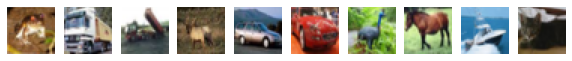

In [ ]:
# Plot the first 10 CIFAR-10 images

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(x_train[i])

#### Introduce two useful functions

In [ ]:
# Introduce function to test model accuracy

def get_test_accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

In [ ]:
# Introduce function that creates a new instance of a simple CNN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

def get_new_model():
    model = Sequential([
        Conv2D(filters=16, input_shape=(32, 32, 3), kernel_size=(3, 3), 
               activation='relu', name='conv_1'),
        Conv2D(filters=8, kernel_size=(3, 3), activation='relu', name='conv_2'),
        MaxPooling2D(pool_size=(4, 4), name='pool_1'),
        Flatten(name='flatten'),
        Dense(units=32, activation='relu', name='dense_1'),
        Dense(units=10, activation='softmax', name='dense_2')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
x_train.shape

(10000, 32, 32, 3)

#### Create simple convolutional neural network classifier

In [ ]:
# Create an instance of the model and show model summary
model=get_new_model()
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
conv_2 (Conv2D)              (None, 28, 28, 8)         1160      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 7, 7, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 392)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                12576     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 14,514
Trainable params: 14,514
Non-trainable params: 0
__________________________________________________

In [ ]:
# Test accuracy of the untrained model, around 10% (random)

get_test_accuracy(model, x_test, y_test)

accuracy: 0.092


#### Train model with checkpoints

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# Create Tensorflow checkpoint object
# Doesn't really work like this in Colab, would need to mount the drive and use full path.
#checkpoint_path ='Imperial_Tensorflow/model_checkpoints/checkpoint'
checkpoint_path = Path('Models/model_checkpoints/checkpoint')  # Relative to CWD!
checkpoint = ModelCheckpoint(filepath = checkpoint_path,
                             frequency = 'epoch',
                             save_weights_only=True,
                             verbose=1)

In [ ]:
# Fit model, with simple checkpoint which saves (and overwrites) model weights every epoch
model.fit(x=x_train,
          y=y_train,
          epochs=3,
          callbacks=[checkpoint]
          )

Epoch 1/3
313/313 [==============================] - 15s 46ms/step - loss: 1.9746 - accuracy: 0.2700

Epoch 00001: saving model to Models/model_checkpoints/checkpoint
Epoch 2/3
313/313 [==============================] - 12s 38ms/step - loss: 1.6549 - accuracy: 0.4033

Epoch 00002: saving model to Models/model_checkpoints/checkpoint
Epoch 3/3
313/313 [==============================] - 12s 40ms/step - loss: 1.5576 - accuracy: 0.4337

Epoch 00003: saving model to Models/model_checkpoints/checkpoint


In [ ]:
# Have a look at what the checkpoint creates
! ls -lh ./Models/model_checkpoints

total 177K
-rw------- 1 root root   77 Aug 28 20:33 checkpoint
-rw------- 1 root root 174K Aug 28 20:33 checkpoint.data-00000-of-00001
-rw------- 1 root root 2.0K Aug 28 20:33 checkpoint.index


In [ ]:
# Evaluate the performance of the trained model
get_test_accuracy(model, x_test, y_test)

accuracy: 0.434


#### Create new model, load weights

In [ ]:
# Create a new instance of the (initialised) model, accuracy around 10% again
model = get_new_model()
get_test_accuracy(model,x_test, y_test)

accuracy: 0.090


In [ ]:
# Load weights -- accuracy is the same as the trained model
model.load_weights(checkpoint_path)
get_test_accuracy(model,x_test, y_test)

accuracy: 0.434


#### Clear directory

In [ ]:
! rm -r ./Models/model_checkpoints/

***
<a id="coding_tutorial_2"></a>
## Model saving criteria

#### Create more customised checkpoint

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# Create Tensorflow checkpoint object with epoch and batch details

# Big issues here, as in TF2.0 samples are counted for the freq, but in TF2.3 on it's batches.
checkpoint_5000_path = \
    'Models/model_checkpoints_5000/checkpoint_{epoch:02d}_{batch:04d}'
checkpoint_5000 = ModelCheckpoint(filepath=checkpoint_5000_path, 
                                  save_weights_only=True, 
                                  save_freq=5000, 
                                  verbose=2)

In [ ]:
x_train.shape

(10000, 32, 32, 3)

In [ ]:
# Create and fit model with checkpoint

model=get_new_model()
model.fit(x=x_train,
          y=y_train,
          epochs=3,
          validation_data=(x_test, y_test),
          batch_size=1,  #Just a work-around to get the files saved.  
          # Obviously it would be better to use save_freq=500 and change the labels.
          # For this week do the assignment on the coursera platform, or use TF2.0.
          callbacks=[checkpoint_5000])

Epoch 1/3
 4991/10000 [=============>................] - ETA: 27s - loss: 1.9352 - accuracy: 0.2845
Epoch 00001: saving model to Models/model_checkpoints_5000/checkpoint_01_5000
 9994/10000 [============================>.] - ETA: 0s - loss: 1.8110 - accuracy: 0.3313
Epoch 00001: saving model to Models/model_checkpoints_5000/checkpoint_01_10000
10000/10000 [==============================] - 57s 6ms/step - loss: 1.8108 - accuracy: 0.3314 - val_loss: 1.6774 - val_accuracy: 0.3860
Epoch 2/3
 4994/10000 [=============>................] - ETA: 26s - loss: 1.5773 - accuracy: 0.4367
Epoch 00002: saving model to Models/model_checkpoints_5000/checkpoint_02_5000
 9992/10000 [============================>.] - ETA: 0s - loss: 1.5222 - accuracy: 0.4472
Epoch 00002: saving model to Models/model_checkpoints_5000/checkpoint_02_10000
10000/10000 [==============================] - 57s 6ms/step - loss: 1.5223 - accuracy: 0.4470 - val_loss: 1.4859 - val_accuracy: 0.4800
Epoch 3/3
 5000/10000 [=============

In [ ]:
# Have a look at what the checkpoint creates
! ls ./Models/model_checkpoints_5000/

checkpoint
checkpoint_01_10000.data-00000-of-00001
checkpoint_01_10000.index
checkpoint_01_5000.data-00000-of-00001
checkpoint_01_5000.index
checkpoint_02_10000.data-00000-of-00001
checkpoint_02_10000.index
checkpoint_02_5000.data-00000-of-00001
checkpoint_02_5000.index
checkpoint_03_10000.data-00000-of-00001
checkpoint_03_10000.index
checkpoint_03_5000.data-00000-of-00001
checkpoint_03_5000.index


#### Work with model saving criteria

In [ ]:
# Use tiny training and test set -- will overfit!
# So this doesn't mess up later work, I've made new variables

x_train_s = x_train[:100]
y_train_s = y_train[:100]
x_test_s = x_test[:100]
y_test_s = y_test[:100]

In [ ]:
# Create a new instance of untrained model

model = get_new_model()

In [ ]:
# Create Tensorflow checkpoint object which monitors the validation accuracy

checkpoint_best_path = Path('Models/model_checkpoints_best/checkpoint')
checkpoint_best = ModelCheckpoint(filepath=checkpoint_best_path, 
                                  save_weights_only=True, 
                                  save_freq='epoch',
                                  save_best_only=True,
                                  verbose=1)

In [ ]:
# Fit the model and save only the weights with the highest validation accuracy

history=model.fit(x=x_train_s, 
                  y=y_train_s,
                  epochs=25, 
                  validation_data=(x_test, y_test),
                  batch_size=1,
                  callbacks=[checkpoint_best],
                  verbose=0)


Epoch 00001: val_loss improved from inf to 2.38819, saving model to Models/model_checkpoints_best/checkpoint

Epoch 00002: val_loss improved from 2.38819 to 2.37796, saving model to Models/model_checkpoints_best/checkpoint

Epoch 00003: val_loss did not improve from 2.37796

Epoch 00004: val_loss improved from 2.37796 to 2.32248, saving model to Models/model_checkpoints_best/checkpoint

Epoch 00005: val_loss did not improve from 2.32248

Epoch 00006: val_loss improved from 2.32248 to 2.26647, saving model to Models/model_checkpoints_best/checkpoint

Epoch 00007: val_loss did not improve from 2.26647

Epoch 00008: val_loss did not improve from 2.26647

Epoch 00009: val_loss did not improve from 2.26647

Epoch 00010: val_loss did not improve from 2.26647

Epoch 00011: val_loss did not improve from 2.26647

Epoch 00012: val_loss did not improve from 2.26647

Epoch 00013: val_loss did not improve from 2.26647

Epoch 00014: val_loss did not improve from 2.26647

Epoch 00015: val_loss did n

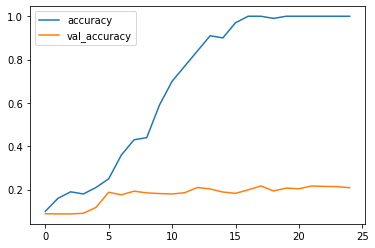

In [ ]:
# Plot training and testing curves

import pandas as pd

df = pd.DataFrame(history.history)
df.plot(y=['accuracy', 'val_accuracy'])

In [ ]:
# Inspect the checkpoint directory

! ls -lh ./Models/model_checkpoints_best

total 177K
-rw------- 1 root root   77 Aug 28 20:37 checkpoint
-rw------- 1 root root 174K Aug 28 20:37 checkpoint.data-00000-of-00001
-rw------- 1 root root 2.0K Aug 28 20:37 checkpoint.index


In [ ]:
# Create a new model with the saved weights
new_model = get_new_model()
new_model.load_weights(checkpoint_best_path)
get_test_accuracy(new_model, x_test_s, y_test_s)

accuracy: 0.130


#### Clear directories

In [ ]:
! rm -r  ./Models/model_checkpoints_5000/
! rm -r  ./Models/model_checkpoints_best/

***
<a id="coding_tutorial_3"></a>
## Saving the entire model

#### Create checkpoint that saves whole model, not just weights

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
#Just checking I've got my original dataset to work with
print(x_train.shape)
print(x_test.shape)

(10000, 32, 32, 3)
(1000, 32, 32, 3)


In [ ]:
# Create Tensorflow checkpoint object

checkpoint_path = Path('Models/model_checkpoints')
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_weights_only=False,
                             frequency='epoch',
                             verbose=1)

In [ ]:
# Create and fit model with checkpoint
model = get_new_model()
model.fit(x=x_train,
          y=y_train,
          epochs=3,
          callbacks=[checkpoint])

Epoch 1/3
313/313 [==============================] - 13s 40ms/step - loss: 1.9652 - accuracy: 0.2721

Epoch 00001: saving model to Models/model_checkpoints


INFO:tensorflow:Assets written to: Models/model_checkpoints/assets


INFO:tensorflow:Assets written to: Models/model_checkpoints/assets


Epoch 2/3
313/313 [==============================] - 12s 37ms/step - loss: 1.6190 - accuracy: 0.4173

Epoch 00002: saving model to Models/model_checkpoints
INFO:tensorflow:Assets written to: Models/model_checkpoints/assets


INFO:tensorflow:Assets written to: Models/model_checkpoints/assets


Epoch 3/3
313/313 [==============================] - 12s 37ms/step - loss: 1.5051 - accuracy: 0.4551

Epoch 00003: saving model to Models/model_checkpoints
INFO:tensorflow:Assets written to: Models/model_checkpoints/assets


INFO:tensorflow:Assets written to: Models/model_checkpoints/assets


#### Inspect what the checkpoint has created

In [ ]:
# Have a look at what the checkpoint creates

! ls -lh ./Models/model_checkpoints/

total 145K
drwx------ 2 root root 4.0K Aug 28 20:38 assets
-rw------- 1 root root  14K Aug 28 20:38 keras_metadata.pb
-rw------- 1 root root 123K Aug 28 20:38 saved_model.pb
drwx------ 2 root root 4.0K Aug 28 20:38 variables


In [ ]:
# Enter variables directory
! ls -lh ./Models/model_checkpoints/variables 

total 179K
-rw------- 1 root root 177K Aug 28 20:38 variables.data-00000-of-00001
-rw------- 1 root root 2.2K Aug 28 20:38 variables.index


In [ ]:
# Get the model's test accuracy
get_test_accuracy(model, x_test, y_test)

accuracy: 0.464


#### Create new model from scratch

In [ ]:
# Delete model
del model

In [ ]:
#check what happened!
try:
    model
except NameError:
   model_exists = False
   print('Model was deleted')
else:
    var_exists = True
    print('Model Exists')

Model was deleted


In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
# Reload model from scratch

model = load_model(checkpoint_path)
get_test_accuracy(model, x_test, y_test)

accuracy: 0.464


#### Use the .h5 format to save model

In [ ]:
# Save the model in .h5 format
save_pth = Path('Models/my_model.h5')
model.save(save_pth)

In [ ]:
# Inspect .h5 file
!ls -lh ./Models/my_model.h5

-rw------- 1 root root 77K Aug 28 20:38 ./Models/my_model.h5


In [ ]:
# Delete model
del model

In [ ]:
# Reload model from scratch
model = load_model(save_pth)
get_test_accuracy(model, x_test, y_test)

accuracy: 0.464


#### Clear directory

In [ ]:
! rm -r ./Models/model_checkpoints
! rm ./Models/my_model.h5

***
<a id="coding_tutorial_4"></a>
## Loading pre-trained Keras models

#### Import and build Keras ResNet50 model

Today we'll be using the ResNet50 model designed by a team at Microsoft Research, available through Keras applications. Please see the description on the [Keras applications page](https://keras.io/applications/#resnet) for details. If you continue using it, please cite it properly! The paper it comes from is:

Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun. "Deep Residual Learning for Image Recognition", 2015.

In the coding tutorial on Coursera, this model is loaded directly from disk. On Colab, you will load the model using the Keras API.

In [ ]:
from tensorflow.keras.applications import ResNet50
model = ResNet50(weights='imagenet')
#model.summary()

#### Import and preprocess 3 sample images

In [ ]:
# Retrieve the image files

!wget -q -O lemon.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1JSgQ9qgi9nO9t2aGEk-zA6lzYNUT9vZJ"
!wget -q -O viaduct.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1sQzMKmyCR5Tur19lP3n1IIlEMG_o6Mct"
!wget -q -O water_tower.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1cPAQD1O6mAiMbg0fmG5HIk8OuO_BSC6J"

In [ ]:
# Import 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img

lemon_img = load_img('lemon.jpg', target_size=(224, 224))
viaduct_img = load_img('viaduct.jpg', target_size=(224, 224))
water_tower_img = load_img('water_tower.jpg', target_size=(224, 224))

#### Use ResNet50 model to classify images

In [ ]:
# Useful function: presents top 5 predictions and probabilities

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import pandas as pd

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...]
    x = preprocess_input(x)
    preds = decode_predictions(model.predict(x), top=5)
    top_preds = pd.DataFrame(columns=['prediction', 'probability'],
                             index=np.arange(5)+1)
    for i in range(5):
        top_preds.loc[i+1, 'prediction'] = preds[0][i][1]
        top_preds.loc[i+1, 'probability'] = preds[0][i][2] 
    return top_preds

##### Image 1: lemon

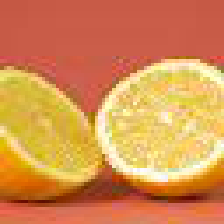

In [ ]:
# Display image
lemon_img

In [ ]:
# Display top 5 predictions
get_top_5_predictions(lemon_img)

,prediction,probability
1,consomme,0.227801
2,lemon,0.221758
3,eggnog,0.151335
4,ladle,0.0400882
5,spotlight,0.0291972


##### Image 2: viaduct

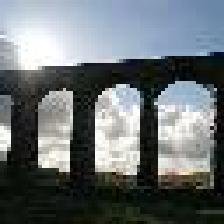

In [ ]:
# Display image
viaduct_img

In [ ]:
# Display top 5 predictions
get_top_5_predictions(viaduct_img)

,prediction,probability
1,vault,0.367951
2,prison,0.111742
3,viaduct,0.110737
4,window_screen,0.0882307
5,fire_screen,0.0206752


##### Image 3: water tower

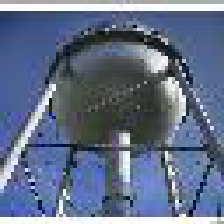

In [ ]:
# Display image
water_tower_img

In [ ]:
# Display top 5 predictions
get_top_5_predictions(water_tower_img)

,prediction,probability
1,solar_dish,0.384682
2,ladle,0.196178
3,planetarium,0.116683
4,strainer,0.04999
5,jigsaw_puzzle,0.0219474


##Полина

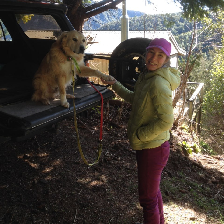

In [ ]:
# Not really expecting this to work, just having fun
mystery_img = load_img('Data/polina_dog_square.jpg', target_size=(224, 224))
mystery_img

In [ ]:
get_top_5_predictions(mystery_img)

,prediction,probability
1,Norwich_terrier,0.13931
2,wallaby,0.0912944
3,Shetland_sheepdog,0.056412
4,Norfolk_terrier,0.0476003
5,ear,0.0449794


***
<a id="coding_tutorial_5"></a>
## Tensorflow Hub modules

#### Import and build Tensorflow Hub MobileNet v1 model

Today we'll be using Google's MobileNet v1 model, available on Tensorflow Hub. Please see the description on the [Tensorflow Hub page](https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4) for details on it's architecture, how it's trained, and the reference. If you continue using it, please cite it properly! The paper it comes from is:

Andrew G. Howard, Menglong Zhu, Bo Chen, Dmitry Kalenichenko, Weijun Wang, Tobias Weyand, Marco Andreetto, Hartwig Adam: "MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications", 2017.

In the coding tutorial on Coursera, this model is loaded directly from disk. On Colab, you will load the model from TensorFlow Hub.

In [ ]:
import tensorflow_hub as hub

In [ ]:
# Build Google's Mobilenet v1 model

module_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4"
model = Sequential([hub.KerasLayer(module_url)])
model.build(input_shape=[None, 160, 160, 3])
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1001)              1343049   
Total params: 1,343,049
Trainable params: 0
Non-trainable params: 1,343,049
_________________________________________________________________


#### Use MobileNet model to classify images

In [ ]:
# Retrieve the image files

!wget -q -O lemon.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1JSgQ9qgi9nO9t2aGEk-zA6lzYNUT9vZJ"
!wget -q -O viaduct.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1sQzMKmyCR5Tur19lP3n1IIlEMG_o6Mct"
!wget -q -O water_tower.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1cPAQD1O6mAiMbg0fmG5HIk8OuO_BSC6J"

In [ ]:
# Import and preprocess 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img

lemon_img = load_img("lemon.jpg", target_size=(160, 160))
viaduct_img = load_img("viaduct.jpg", target_size=(160, 160))
water_tower_img = load_img("water_tower.jpg", target_size=(160, 160))

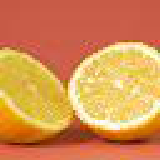

In [ ]:
lemon_img

In [ ]:
# Read in categories text file
# Note, the link to this was missing.  I copied the text file from the course page onto gdrive

with open('Data/imagenet_categories.txt') as txt_file:
    categories = txt_file.read().splitlines()

In [ ]:
# Useful function: presents top 5 predictions

import pandas as pd

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...] / 255.0
    preds = model.predict(x)
    top_preds = pd.DataFrame(columns=['prediction'],
                             index=np.arange(5)+1)
    sorted_index = np.argsort(-preds[0])
    for i in range(5):
        ith_pred = categories[sorted_index[i]]
        top_preds.loc[i+1, 'prediction'] = ith_pred
            
    return top_preds

##### Image 1: lemon

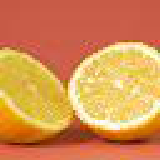

In [ ]:
lemon_img

In [ ]:
get_top_5_predictions(lemon_img)

,prediction
1,shower cap
2,tray
3,candle
4,brassiere
5,African chameleon


##### Image 2: viaduct

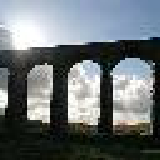

In [ ]:
viaduct_img

In [ ]:
get_top_5_predictions(viaduct_img)

,prediction
1,viaduct
2,pier
3,dam
4,prison
5,solar dish


##### Image 3: water tower

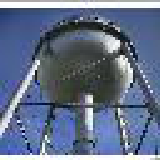

In [ ]:
water_tower_img

In [ ]:
get_top_5_predictions(water_tower_img)

,prediction
1,solar dish
2,water tower
3,aircraft carrier
4,jigsaw puzzle
5,oxygen mask


##Полина

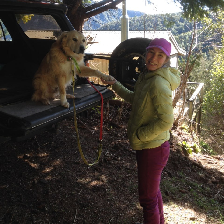

In [ ]:
mystery_img

In [ ]:
get_top_5_predictions(mystery_img)

,prediction
1,chain saw
2,rotisserie
3,military uniform
4,rifle
5,apiary
